In [1]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, Imagenette
import tqdm
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from IPython.display import display, clear_output

from SRDiffusion import ScoreNet, ExponentialMovingAverage
from SDE import marginal_prob_std_fn, loss_fn, loss_fn_sr, diffusion_coeff_fn, loss_fn_sr_imagenette
from samplers import ode_sampler
from globals import device

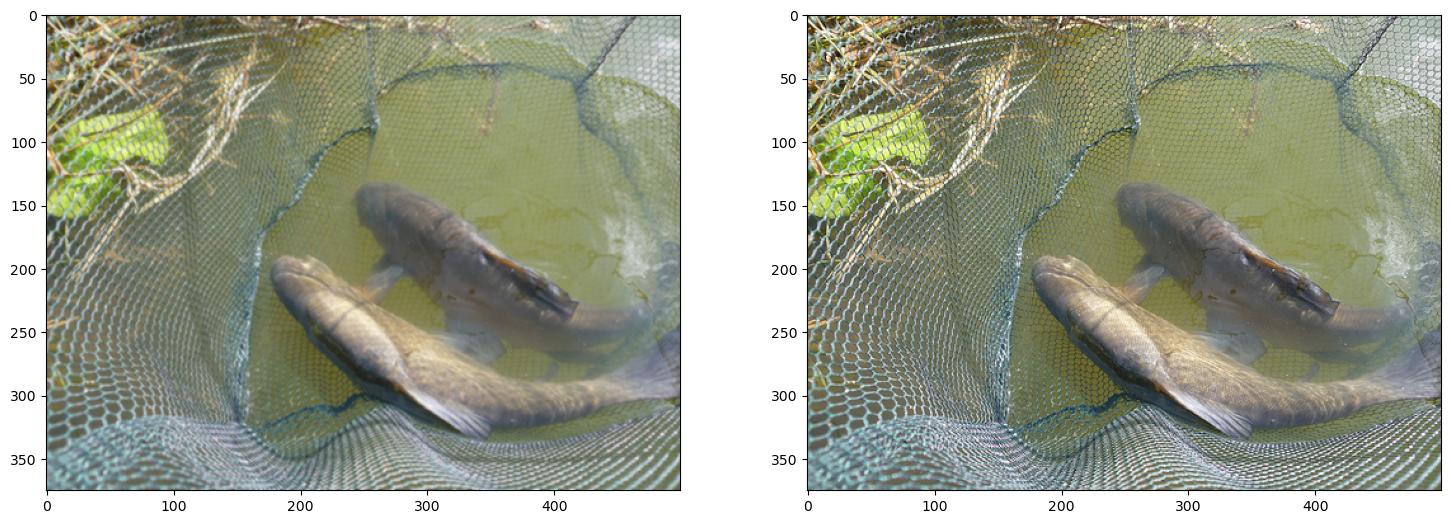

In [ ]:
# Standard ImageNet normalization values (common practice for Imagenette)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

imagenette_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]
)
dataset = Imagenette(".", split="train", transform=imagenette_transforms, download=True)

x_hat = torchvision.transforms.functional.adjust_sharpness(dataset[0][0], 0.0001)
x_hat = np.transpose(x_hat.numpy(), (1,2,0))
x = np.transpose(dataset[0][0].cpu().numpy(), (1,2,0))
fig, axis = plt.subplots(1,2,figsize=(18, 10))
axis[0].imshow(x_hat)
axis[1].imshow(x)
plt.show()

### Train Generation Diffusion Model

In [3]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
n_epochs = 800
## size of a mini-batch
batch_size = 32
## learning rate
lr = 1e-3
overfit = True
dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)

if overfit:
    dataset = torch.utils.data.Subset(dataset, [0])
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
optimizer = Adam(score_model.parameters(), lr=lr)

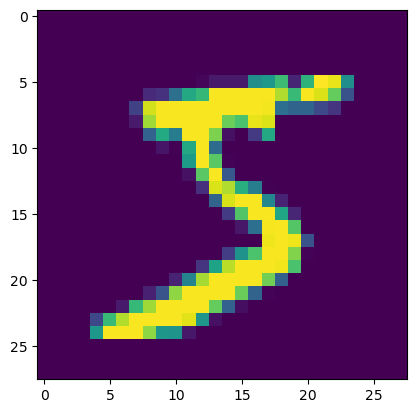

In [22]:
img_np = np.transpose(dataset[0][0].cpu().numpy(), (1,2,0))

plt.imshow(img_np, label="test")

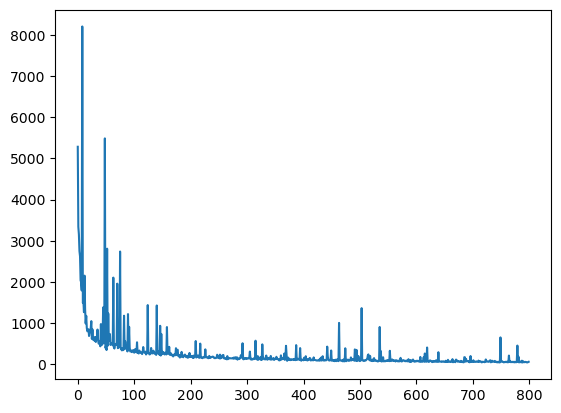

Average Loss: 61.961163: 100%|██████████| 800/800 [31:14<00:00,  2.34s/it]


In [24]:
# Create a figure and a line object
fig, ax = plt.subplots()
line, = ax.plot([], [])
display(fig)
x_data = []
y_data = []

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss, rand_t, z, std, perturbed_x, score = loss_fn(score_model, x, marginal_prob_std_fn, debug=overfit)
        # print(f"Rand_t is {rand_t}")
        # print(f"Latent noise is {z.shape} (compared to base shape {x.shape})")
        # print(f"std is {std}")
        x_np = np.transpose(x.cpu().numpy()[0, :, :, :], (1,2,0))
        perturbed_np = np.transpose(perturbed_x.cpu().numpy()[0, :, :, :], (1,2,0))
        # f, axarr = plt.subplots(1,2)
        # axarr[0].imshow(x_np)
        # axarr[1].imshow(perturbed_np)
        # plt.show()
        # print(f"Scroe is {score.shape}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    
    x_data.append(epoch)
    y_data.append(avg_loss / num_items)
    line.set_data(x_data, y_data)
    ax.relim() 
    ax.autoscale_view(True,True,True)
    clear_output(wait=True)
    display(fig)
    # print(f"received loss {loss}")
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), "ckpt.pth")

plt.close()

/Users/hannesleonhard/Documents/MasterInfo/SR-Diffusion/SDE.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device, dtype=torch.float32)


Number of function evaluations: 560


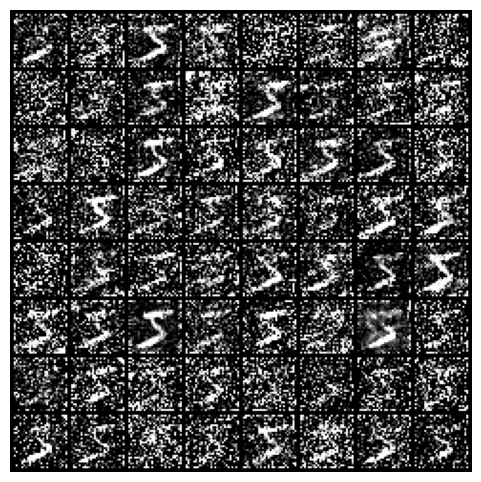

In [ ]:
from torchvision.utils import make_grid

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64

samples = ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

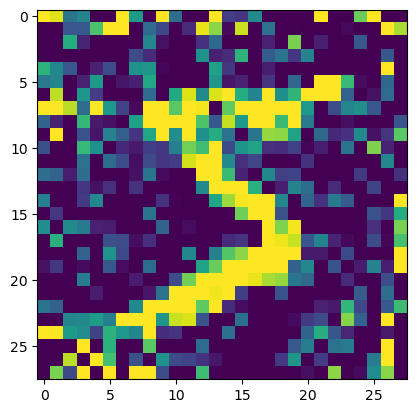

In [6]:
img_np = np.transpose(samples[2].cpu().numpy(), (1,2,0))

plt.imshow(img_np, label="test")

### Train SR Diffusion Model

In [2]:
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=marginal_prob_std_fn, in_channels=2)
)
score_model = score_model.to(device)
n_epochs = 200
## size of a mini-batch
batch_size = 16
## learning rate
lr = 1e-4
overfit = False
dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
if overfit:
    dataset = torch.utils.data.Subset(dataset, [0, 1])
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
optimizer = Adam(score_model.parameters(), lr=lr)

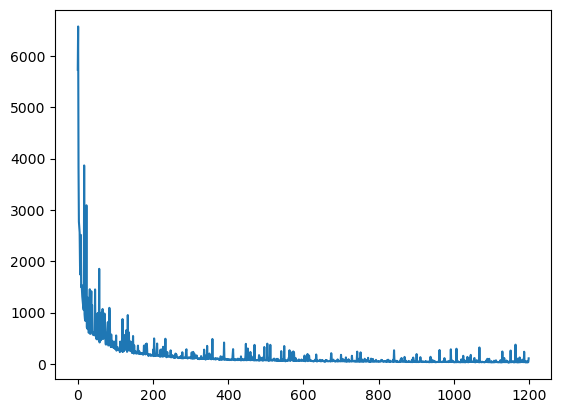

Average Loss: 106.903343: 100%|██████████| 1200/1200 [51:24<00:00,  2.57s/it]


In [ ]:
# Create a figure and a line object
fig, ax = plt.subplots()
(line,) = ax.plot([], [])
display(fig)
x_data = []
y_data = []
base_model = getattr(score_model, 'module', score_model)
ema = ExponentialMovingAverage(base_model, decay=0.9999)

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss, rand_t, z, std, perturbed_x, score = loss_fn_sr(
            score_model, x, marginal_prob_std_fn, debug=overfit
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update(base_model)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    x_data.append(epoch)
    y_data.append(avg_loss / num_items)
    line.set_data(x_data, y_data)
    ax.relim()
    ax.autoscale_view(True, True, True)
    clear_output(wait=True)
    display(fig)
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), "ckpt.pth")

plt.close()

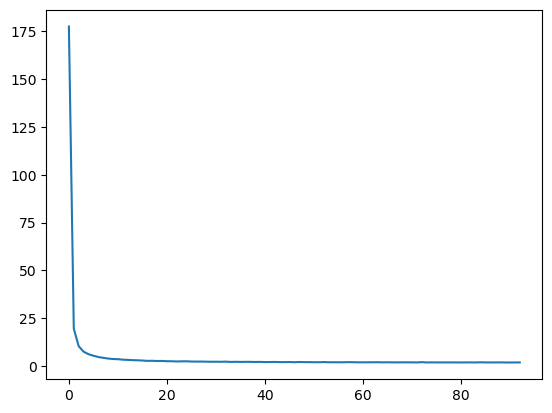

Average Loss: 1.954321:  46%|████▋     | 93/200 [3:51:08<4:35:28, 154.47s/it]libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11e9994c0>
Traceback (most recent call last):
  File "/Users/hannesleonhard/micromamba/envs/tumai-helmholtz/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Users/hannesleonhard/micromamba/envs/tumai-helmholtz/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/hannesleonhard/micromamba/envs/tu

KeyboardInterrupt: 

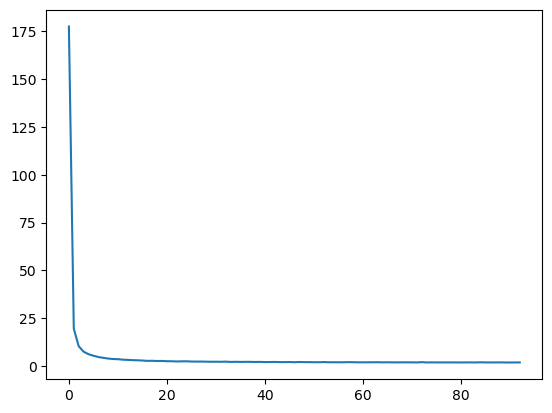

In [3]:
# Create a figure and a line object
fig, ax = plt.subplots()
(line,) = ax.plot([], [])
display(fig)
x_data = []
y_data = []
base_model = getattr(score_model, "module", score_model)
ema = ExponentialMovingAverage(base_model, decay=0.9999, device=device)

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss = loss_fn_sr(
            score_model, x, marginal_prob_std_fn, debug=False
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update(base_model)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    x_data.append(epoch)
    y_data.append(avg_loss / num_items)
    line.set_data(x_data, y_data)
    ax.relim()
    ax.autoscale_view(True, True, True)
    clear_output(wait=True)
    display(fig)
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    ckpt = {
        "model_state": score_model.state_dict(),  # save DataParallel wrapper state
        "ema_shadow": ema.state_dict(),  # save EMA shadow (CPU tensors)
        "optimizer_state": optimizer.state_dict(),  # optional
        "epoch": epoch,
    }
    torch.save(ckpt, "ckpt_with_ema.pth")

plt.close()

Number of function evaluations: 248


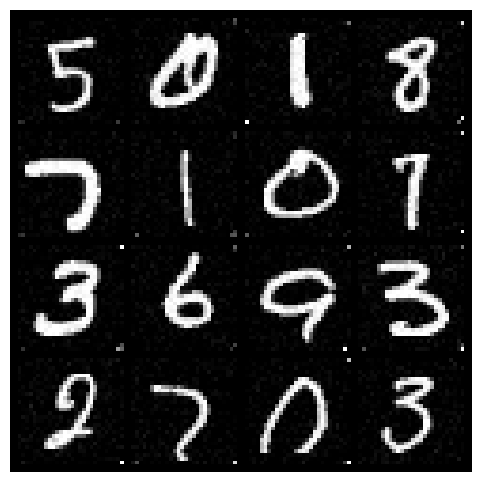

In [9]:
from torchvision.utils import make_grid
import random

ckpt = torch.load('ckpt_with_ema.pth', map_location=device)
score_model.load_state_dict(ckpt['model_state'])
base_model = getattr(score_model, 'module', score_model)
ema = ExponentialMovingAverage(base_model, decay=0.9999, device=device)
ema.load_state_dict(ckpt['ema_shadow'])

conditioning_x = torch.zeros(sample_batch_size, 1, 28, 28)
indices = random.sample(range(len(dataset)), sample_batch_size)
for i, idx in enumerate(indices):
    img, _ = dataset[idx]  # assuming dataset returns (image, label)
    img = torchvision.transforms.functional.adjust_sharpness(img, 0.01)
    conditioning_x[i] = img
conditioning_x = conditioning_x.to(device=device)
samples = ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size,
                  conditioning_x=conditioning_x,
                  ema=ema)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

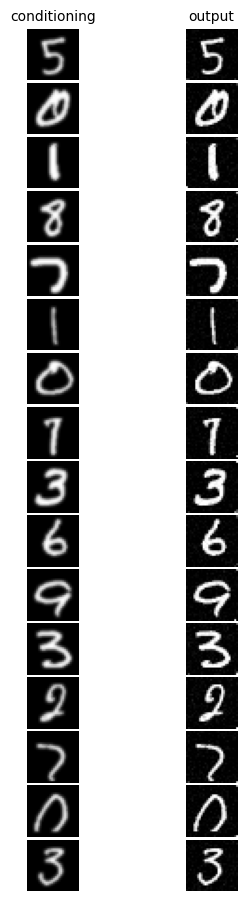

In [10]:
conds_cpu = conditioning_x.detach().cpu().numpy()  # shape (B,1,28,28)
samples_cpu = samples.detach().cpu().numpy()       # shape (B,1,28,28)

# Create figure with sample_batch_size rows and 2 columns
n_rows = sample_batch_size
fig, axes = plt.subplots(n_rows, 2, figsize=(4, max(6, n_rows * 0.7)))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# Optional: set column titles
axes[0, 0].set_title("conditioning", fontsize=10)
axes[0, 1].set_title("output", fontsize=10)

for i in range(n_rows):
    # conditioning image (left)
    ax = axes[i, 0]
    img_cond = conds_cpu[i].squeeze()   # (28,28)
    ax.imshow(img_cond, cmap='gray', vmin=0.0, vmax=1.0)
    ax.axis('off')

    # generated sample (right)
    ax = axes[i, 1]
    img_out = samples_cpu[i].squeeze()  # (28,28)
    ax.imshow(img_out, cmap='gray', vmin=0.0, vmax=1.0)
    ax.axis('off')

# If sample_batch_size == 1, axes will be 1D; above assumes 2D. Guarding for that:
if sample_batch_size == 1:
    plt.close(fig)
    fig, axes = plt.subplots(1, 2, figsize=(4, 3))
    axes[0].imshow(conds_cpu[0].squeeze(), cmap='gray', vmin=0.0, vmax=1.0); axes[0].axis('off'); axes[0].set_title("conditioning")
    axes[1].imshow(samples_cpu[0].squeeze(), cmap='gray', vmin=0.0, vmax=1.0); axes[1].axis('off'); axes[1].set_title("output")

plt.show()

## Imagenette SR

In [2]:
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=marginal_prob_std_fn, in_channels=6)
)
score_model = score_model.to(device)
n_epochs = 50
## size of a mini-batch
batch_size = 4
## learning rate
lr = 1e-4
overfit = False
# Standard ImageNet normalization values (common practice for Imagenette)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
imagenette_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 512)),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)
dataset = Imagenette(".", split="train", transform=imagenette_transforms, download=True)
if overfit:
    dataset = torch.utils.data.Subset(dataset, [0, 1])
dataset = torch.utils.data.Subset(dataset, np.random.choice([i for i in range(len(dataset))], size=len(dataset)//50, replace=False))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
optimizer = Adam(score_model.parameters(), lr=lr)

In [3]:
len(dataset)

189

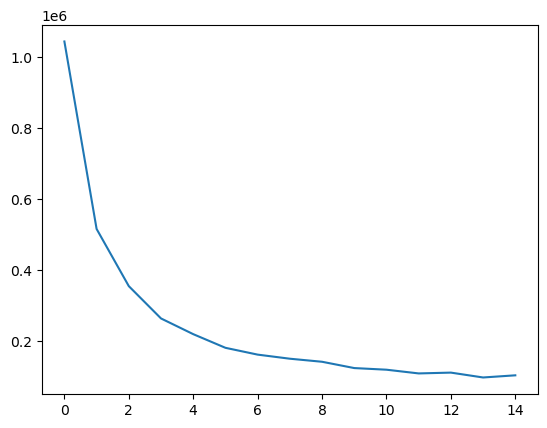

Average Loss: 104496.760045:  30%|███       | 15/50 [14:17<33:19, 57.14s/it]


KeyboardInterrupt: 

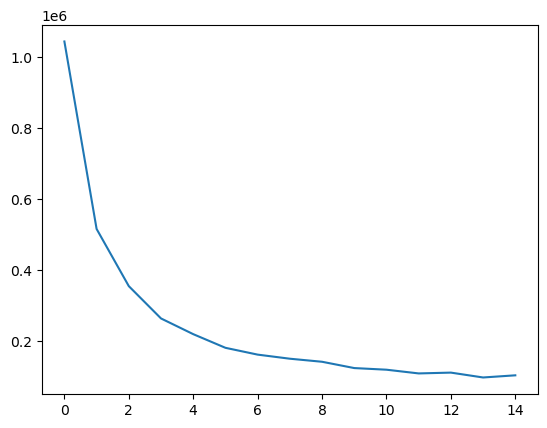

In [4]:
# Create a figure and a line object
fig, ax = plt.subplots()
(line,) = ax.plot([], [])
display(fig)
x_data = []
y_data = []
base_model = getattr(score_model, "module", score_model)
ema = ExponentialMovingAverage(base_model, decay=0.9999, device=device)

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss = loss_fn_sr_imagenette(
            score_model, x, marginal_prob_std_fn, debug=False
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update(base_model)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    x_data.append(epoch)
    y_data.append(avg_loss / num_items)
    line.set_data(x_data, y_data)
    ax.relim()
    ax.autoscale_view(True, True, True)
    clear_output(wait=True)
    display(fig)
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    ckpt = {
        "model_state": score_model.state_dict(),  # save DataParallel wrapper state
        "ema_shadow": ema.state_dict(),  # save EMA shadow (CPU tensors)
        "optimizer_state": optimizer.state_dict(),  # optional
        "epoch": epoch,
    }
    torch.save(ckpt, "ckpt_with_ema.pth")

plt.close()